In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as gbc
from pcfm import plot_confusion_matrix
from pfimp import plot_feature_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from pauroc import cal_auroc

In [3]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
# Whitening
X -= np.mean(X,axis=0)
X /= np.std(X,axis=0)

In [4]:
num_iterations = 20
k_fold = 5
smote = SMOTE(ratio=1.0)

## Gradient Boosting Classifier

In [5]:
kf = StratifiedKFold(k_fold,shuffle=True)
## Ytest
mega_ytest = []
## NON-SMOTE
fimp  = [] # feature importances
prob  = [] # probability 
metrc = [] # recall scores
metpr = [] # precision scores
metll = [] # log-loss 
metac = [] # accuracy
metf1 = [] # F1-score
metmc = [] # Matthews correlation coefficient
metgm = [] # G-Mean
metcm = [] # Confusion matrix
metfp = [] # FPR 
## SMOTE
sfimp  = [] # feature importances
sprob  = [] # probability
smetrc = [] # recall scores
smetpr = [] # precision scores
smetll = [] # log-loss 
smetac = [] # accuracy
smetf1 = [] # F1-score
smetmc = [] # Matthews correlation coefficient
smetgm = [] # G-Mean
smetcm = [] # Confusion matrix
smetfp = [] # FPR 

In [6]:
for rc in xrange(num_iterations):
    print "[",rc,'] Iteration...Starting'
    for tr,te in kf.split(X,y):
        xtrain, xtest = X[tr], X[te]
        ytrain, ytest = y[tr], y[te]
        sxtrain, sytrain = smote.fit_sample(xtrain,ytrain)
        ##
        gf  = gbc(n_estimators=250,max_depth=5,min_samples_leaf=2,learning_rate=1e-1)
        sgf = gbc(n_estimators=250,max_depth=5,min_samples_leaf=2,learning_rate=1e-1)
        gf.fit(xtrain,ytrain)
        sgf.fit(sxtrain, sytrain)
        ##
        ypredict = gf.predict(xtest)
        sypredict = sgf.predict(xtest)
        ## NON-SMOTE
        fimp.append(gf.feature_importances_)
        prob.append(gf.predict_proba(xtest))
        metrc.append(recall_score(ytest,ypredict))
        metpr.append(precision_score(ytest,ypredict))
        metac.append(accuracy_score(ytest,ypredict))
        metf1.append(f1_score(ytest,ypredict))
        metll.append(log_loss(ytest,ypredict))
        metmc.append(matthews_corrcoef(ytest,ypredict))
        cmyy = confusion_matrix(ytest,ypredict)
        metcm.append(cmyy)
        specificity = (1.*cmyy[0,0])/(cmyy[0,0] + cmyy[0,1])
        metgm.append(np.sqrt(recall_score(ytest,ypredict)*specificity))
        metfp.append(1.*cmyy[0,1]/(cmyy[0,0]+cmyy[0,1]))
        ## SMOTE
        sfimp.append(sgf.feature_importances_)
        sprob.append(sgf.predict_proba(xtest))
        smetrc.append(recall_score(ytest,sypredict))
        smetpr.append(precision_score(ytest,sypredict))
        smetac.append(accuracy_score(ytest,sypredict))
        smetf1.append(f1_score(ytest,sypredict))
        smetll.append(log_loss(ytest,sypredict))
        smetmc.append(matthews_corrcoef(ytest,sypredict))
        scmyy = confusion_matrix(ytest,sypredict)
        smetcm.append(scmyy)
        sspecificity = (1.*scmyy[0,0])/(scmyy[0,0] + scmyy[0,1])
        smetgm.append(np.sqrt(recall_score(ytest,sypredict)*sspecificity))
        smetfp.append(1.*scmyy[0,1]/(scmyy[0,0]+scmyy[0,1]))
        ##
        mega_ytest.append(ytest)

[ 0 ] Iteration...Starting
[ 1 ] Iteration...Starting
[ 2 ] Iteration...Starting
[ 3 ] Iteration...Starting
[ 4 ] Iteration...Starting
[ 5 ] Iteration...Starting
[ 6 ] Iteration...Starting
[ 7 ] Iteration...Starting
[ 8 ] Iteration...Starting
[ 9 ] Iteration...Starting
[ 10 ] Iteration...Starting
[ 11 ] Iteration...Starting
[ 12 ] Iteration...Starting
[ 13 ] Iteration...Starting
[ 14 ] Iteration...Starting
[ 15 ] Iteration...Starting
[ 16 ] Iteration...Starting
[ 17 ] Iteration...Starting
[ 18 ] Iteration...Starting
[ 19 ] Iteration...Starting


In [7]:
print "The recall score is    {0:0.4f} +/- {1:2.3f}".format(np.mean(metrc),np.std(metrc))
print "The precision score is {0:0.4f} +/- {1:2.3f}".format(np.mean(metpr),np.std(metpr))
print "The accuracy is        {0:0.4f} +/- {1:2.3f}".format(np.mean(metac),np.std(metac))
print "The f1 score is        {0:0.4f} +/- {1:2.3f}".format(np.mean(metf1),np.std(metf1))
print "The logloss score is   {0:0.4f} +/- {1:2.3f}".format(np.mean(metll),np.std(metll))
print "The MCC is             {0:0.4f} +/- {1:2.3f}".format(np.mean(metmc),np.std(metmc))
print "The G-Mean is          {0:0.4f} +/- {1:2.3f}".format(np.mean(metgm),np.std(metgm))
print "The FPR is             {0:2.3e} +/- {1:2.3e}".format(np.mean(metfp),np.std(metfp))

The recall score is    0.9948 +/- 0.006
The precision score is 0.9880 +/- 0.006
The accuracy is        0.9998 +/- 0.000
The f1 score is        0.9914 +/- 0.004
The logloss score is   0.0080 +/- 0.004
The MCC is             0.9913 +/- 0.004
The G-Mean is          0.9973 +/- 0.003
The FPR is             1.648e-04 +/- 8.757e-05


In [8]:
print "The recall score is    {0:0.4f} +/- {1:2.3f}".format(np.mean(smetrc),np.std(smetrc))
print "The precision score is {0:0.4f} +/- {1:2.3f}".format(np.mean(smetpr),np.std(smetpr))
print "The accuracy is        {0:0.4f} +/- {1:2.3f}".format(np.mean(smetac),np.std(smetac))
print "The f1 score is        {0:0.4f} +/- {1:2.3f}".format(np.mean(smetf1),np.std(smetf1))
print "The logloss score is   {0:0.4f} +/- {1:2.3f}".format(np.mean(smetll),np.std(smetll))
print "The MCC is             {0:0.4f} +/- {1:2.3f}".format(np.mean(smetmc),np.std(smetmc))
print "The G-Mean is          {0:0.4f} +/- {1:2.3f}".format(np.mean(smetgm),np.std(smetgm))
print "The FPR is             {0:2.3e} +/- {1:2.3e}".format(np.mean(smetfp),np.std(smetfp))

The recall score is    0.9949 +/- 0.005
The precision score is 0.9858 +/- 0.007
The accuracy is        0.9997 +/- 0.000
The f1 score is        0.9903 +/- 0.004
The logloss score is   0.0090 +/- 0.004
The MCC is             0.9902 +/- 0.004
The G-Mean is          0.9974 +/- 0.002
The FPR is             1.956e-04 +/- 1.018e-04


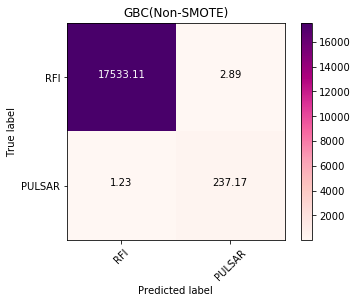

In [9]:
plot_confusion_matrix(np.mean(metcm,axis=0),clname,cmap=plt.cm.RdPu,title='GBC(Non-SMOTE)',colmap=True)
plt.show()

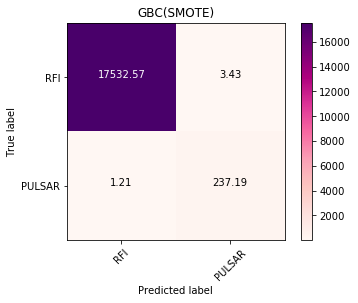

In [10]:
plot_confusion_matrix(np.mean(smetcm,axis=0),clname,cmap=plt.cm.RdPu,title='GBC(SMOTE)',colmap=True)
plt.show()

In [11]:
fimp_np = np.array(fimp)
sfimp_np = np.array(sfimp)

In [12]:
fimp_np.shape

(100, 6)

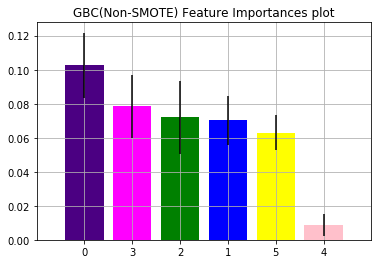

In [13]:
plot_feature_importance(np.mean(fimp,0),np.std(fimp,0),'GBC(Non-SMOTE) Feature Importances plot')
plt.show()

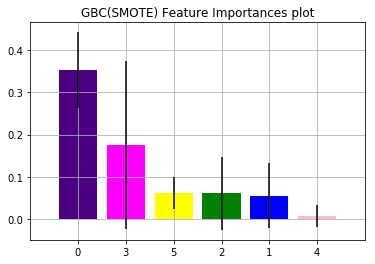

In [14]:
plot_feature_importance(np.mean(sfimp,0),np.std(sfimp,0),'GBC(SMOTE) Feature Importances plot')
plt.show()

In [15]:
np.min([x.shape[0] for x in prob]), np.min([x.shape[0] for x in sprob]), np.min([x.shape[0] for x in mega_ytest])

(17774, 17774, 17774)

In [16]:
hprob = np.array([x[:17774] for x in prob]) 
hsprob = np.array([x[:17774] for x in sprob])
hmega = np.array([x[:17774] for x in mega_ytest])

In [17]:
hprob.shape, hsprob.shape, hmega.shape

((100, 17774, 2), (100, 17774, 2), (100, 17774))

In [18]:
ret = cal_auroc(hmega,hprob,hsprob)

In [19]:
print "Non-SMOTE Mean AuROC {0:0.4f} +/- {1:2.5f}".format(ret['non_smote_auc'][0],ret['non_smote_auc'][1])
print "SMOTE Mean AuROC     {0:0.4f} +/- {1:2.5f}".format(ret['smote_auc'][0],ret['smote_auc'][1])

Non-SMOTE Mean AuROC 0.9949 +/- 0.00002
SMOTE Mean AuROC     0.9935 +/- 0.00272


In [20]:
import pickle
with open('gbc_data.dat','wb') as f:
    pickle.dump([hmega,hprob,hsprob],f)

In [ ]:
import pickle
with open('gbc_fimp.dat','wb') as ff:
    pickle.dump([fimp,sfimp],ff)